In [ ]:
#  SETUP & INSTALL DEPENDENCIES

import os
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import librosa
import timm
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm.auto import tqdm
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, auc
)
import torchvision.transforms as transforms
import warnings
import json
from datetime import datetime
import subprocess
import shutil

warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f" Device: {device}")
print(f" PyTorch: {torch.__version__}")


 Device: cuda
 PyTorch: 2.9.0+cu126


In [ ]:

#  MOUNT GOOGLE DRIVE & DOWNLOAD DATASET

from google.colab import drive
drive.mount('/content/drive')

# Set project directory (UBAH SESUAI LOKASI ANDA)
PROJECT_DIR = "/content/drive/MyDrive/deepfake_checkpoints/Multi Modal"
os.makedirs(PROJECT_DIR, exist_ok=True)
print(f" Project dir: {PROJECT_DIR}")


# Check model files exist
AUDIO_MODEL_PATH = os.path.join(PROJECT_DIR, "best_audio_xception.pth")
VIDEO_MODEL_PATH = os.path.join(PROJECT_DIR, "epoch_007.pt")

print(f"\n Checking model files...")
print(f"   Audio model: {'Found' if os.path.exists(AUDIO_MODEL_PATH) else ' NOT FOUND'}")
print(f"   Video model: {'Found' if os.path.exists(VIDEO_MODEL_PATH) else ' NOT FOUND'}")

if not os.path.exists(AUDIO_MODEL_PATH) or not os.path.exists(VIDEO_MODEL_PATH):
    print("\n  Please upload model files to Google Drive!")
    print(f"   Expected location: {PROJECT_DIR}")



Mounted at /content/drive
 Project dir: /content/drive/MyDrive/deepfake_checkpoints/Multi Modal

 Checking model files...
   Audio model: Found
   Video model: Found


In [ ]:
# ============================================================
# DOWNLOAD DATASETS DARI KAGGLE
# ============================================================
import kagglehub

def find_file(root, filename):
    for r, _, files in os.walk(root):
        if filename in files:
            return os.path.join(r, filename)
    return None

def find_dir(root, dirname):
    for r, dirs, _ in os.walk(root):
        if dirname in dirs:
            return os.path.join(r, dirname)
    return None

# ============================================================
# DOWNLOAD 1: Raw Videos Dataset
# ============================================================
print(" [1/2] Downloading RAW VIDEO dataset...")
print("   Dataset: mbulsss/fakeavceleb")
print("   (This may take a few minutes)")

video_dataset_path = kagglehub.dataset_download("mbulsss/fakeavceleb")
print(f" Video dataset: {video_dataset_path}")

# Find meta_data.csv (info semua video)
meta_path = find_file(video_dataset_path, "meta_data.csv")
print(f"meta_data.csv: {meta_path}")

# Load metadata
meta_df = pd.read_csv(meta_path)
print(f"   Total videos: {len(meta_df)}")

# ============================================================
# DOWNLOAD 2: Audio Dataset (contains test split files!)
# ============================================================
print("\n [2/2] Downloading AUDIO dataset (for test split)...")
print("   Dataset: mbulsss/fakeavceleb-audio")

audio_dataset_path = kagglehub.dataset_download("mbulsss/fakeavceleb-audio")
print(f" Audio dataset: {audio_dataset_path}")

# Find test split file
test_split_path = find_file(audio_dataset_path, "metadata_test_identity.csv")
print(f" metadata_test_identity.csv: {test_split_path}")

if test_split_path:
    test_split_df = pd.read_csv(test_split_path)
    print(f"   Test samples: {len(test_split_df)}")
    print(f"   Columns: {test_split_df.columns.tolist()}")
else:
    print(" Test split file tidak ditemukan!")

print("\n" + "="*50)
print(" Dataset Summary:")
print(f"   Video dataset: {len(meta_df)} videos")
print(f"   Test split: {len(test_split_df) if test_split_path else 'N/A'} samples")
print("="*50)


 [1/2] Downloading RAW VIDEO dataset...
   Dataset: mbulsss/fakeavceleb
   (This may take a few minutes)


100%|██████████| 5.97G/5.97G [04:48<00:00, 22.2MB/s]

Extracting files...


 Video dataset: /root/.cache/kagglehub/datasets/mbulsss/fakeavceleb/versions/1
meta_data.csv: /root/.cache/kagglehub/datasets/mbulsss/fakeavceleb/versions/1/FakeAVCeleb_v1.2/meta_data.csv
   Total videos: 21566

 [2/2] Downloading AUDIO dataset (for test split)...
   Dataset: mbulsss/fakeavceleb-audio
Using Colab cache for faster access to the 'fakeavceleb-audio' dataset.
 Audio dataset: /kaggle/input/fakeavceleb-audio
 metadata_test_identity.csv: /kaggle/input/fakeavceleb-audio/metadata_test_identity.csv
   Test samples: 13962
   Columns: ['path', 'rel_path', 'identity_id', 'label', 'av_category', 'split']

 Dataset Summary:
   Video dataset: 21566 videos
   Test split: 13962 samples


In [ ]:
#  CREATE TEST SET FROM metadata_test_identity.csv

print(" Processing test split from metadata_test_identity.csv...")
print(f"   Source: {test_split_path}")

# Check columns in test split
print(f"\n Test split columns: {test_split_df.columns.tolist()}")
print(f"   First few rows:")
print(test_split_df.head(3))

# Get identity IDs from test split
# Check which column contains the identity
identity_col = None
for col in ['identity_id', 'source', 'id', 'video_id']:
    if col in test_split_df.columns:
        identity_col = col
        break

if identity_col is None:
    # Use first column
    identity_col = test_split_df.columns[0]
    print(f" Using first column as identity: {identity_col}")
else:
    print(f" Using column '{identity_col}' for identity matching")

test_identity_ids = set(test_split_df[identity_col].unique())
print(f"   Unique test identities: {len(test_identity_ids)}")

# Match with meta_df (raw video metadata)
# Need to find matching column in meta_df
print(f"\n Matching with video metadata...")
print(f"   meta_df columns: {meta_df.columns.tolist()}")

# Try to match by 'source' column in meta_df
if 'source' in meta_df.columns:
    # Filter meta_df to only test identities
    test_df = meta_df[meta_df['source'].isin(test_identity_ids)].copy()
    print(f"   Matched videos: {len(test_df)}")
else:
    print(" Cannot find matching column, using all test split data")
    test_df = meta_df.copy()

# Add labels: RealVideo-RealAudio = 1 (REAL), others = 0 (FAKE)
test_df['label'] = (test_df['type'] == 'RealVideo-RealAudio').astype(int)

print(f"\n Test set from split:")
print(f"   REAL: {(test_df['label'] == 1).sum()}")
print(f"   FAKE: {(test_df['label'] == 0).sum()}")

# Balance the test set
real_test = test_df[test_df['label'] == 1]
fake_test = test_df[test_df['label'] == 0]

print(f"\n Balancing test set...")
n_real = len(real_test)
n_fake = len(fake_test)

if n_fake > n_real and n_real > 0:
    fake_test_sampled = fake_test.sample(n=n_real, random_state=42)
    test_df = pd.concat([real_test, fake_test_sampled], ignore_index=True)
elif n_real > n_fake and n_fake > 0:
    real_test_sampled = real_test.sample(n=n_fake, random_state=42)
    test_df = pd.concat([real_test_sampled, fake_test], ignore_index=True)

test_df = test_df.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"\n Final BALANCED test set:")
print(f"   REAL: {(test_df['label'] == 1).sum()}")
print(f"   FAKE: {(test_df['label'] == 0).sum()}")
print(f"   Total: {len(test_df)}")

#  VERIFY NO DATA LEAKAGE: Check train/test identity overlap

print(f"\n" + "="*70)
print(" VERIFYING NO DATA LEAKAGE")
print("="*70)

# Load train split to check overlap
train_split_path = find_file(audio_dataset_path, "metadata_train_identity.csv")
val_split_path = find_file(audio_dataset_path, "metadata_val_identity.csv")

if train_split_path:
    train_split_df = pd.read_csv(train_split_path)
    train_identity_ids = set(train_split_df[identity_col].unique())

    print(f"\n Train split:")
    print(f"   Total samples: {len(train_split_df)}")
    print(f"   Unique identities: {len(train_identity_ids)}")

    # Check overlap
    overlap = test_identity_ids.intersection(train_identity_ids)

    print(f"\n Checking overlap with TEST identities:")
    print(f"   Test identities: {len(test_identity_ids)}")
    print(f"   Overlap with train: {len(overlap)}")

    if len(overlap) > 0:
        print(f"\n WARNING: DATA LEAKAGE DETECTED! ")
        print(f"   {len(overlap)} identities appear in BOTH train and test!")
        print(f"   Overlapping identities: {list(overlap)[:10]}...")
        print(f"\n    This will inflate results!")
        print(f"    Need to fix before paper submission!")
    else:
        print(f"\n NO DATA LEAKAGE!")
        print(f"   Test identities are completely separate from train")
        print(f"   Results are valid for paper! ")

    # Check val split too
    if val_split_path:
        val_split_df = pd.read_csv(val_split_path)
        val_identity_ids = set(val_split_df[identity_col].unique())
        val_overlap = test_identity_ids.intersection(val_identity_ids)

        print(f"\n Checking overlap with VAL identities:")
        print(f"   Val identities: {len(val_identity_ids)}")
        print(f"   Overlap with test: {len(val_overlap)}")

        if len(val_overlap) > 0:
            print(f"   {len(val_overlap)} identities overlap (this is OK for val)")
        else:
            print(f"    No overlap")





 Processing test split from metadata_test_identity.csv...
   Source: /kaggle/input/fakeavceleb-audio/metadata_test_identity.csv

 Test split columns: ['path', 'rel_path', 'identity_id', 'label', 'av_category', 'split']
   First few rows:
                                                path  \
0  /content/melspec_windows_fixed/RealVideo-RealA...   
1  /content/melspec_windows_fixed/RealVideo-RealA...   
2  /content/melspec_windows_fixed/RealVideo-RealA...   

                                            rel_path identity_id  label  \
0  RealVideo-RealAudio/Caucasian (American)/men/i...     id00264      0   
1  RealVideo-RealAudio/Caucasian (American)/men/i...     id00264      0   
2  RealVideo-RealAudio/Caucasian (American)/men/i...     id00264      0   

           av_category split  
0  RealVideo-RealAudio  test  
1  RealVideo-RealAudio  test  
2  RealVideo-RealAudio  test  
 Using column 'identity_id' for identity matching
   Unique test identities: 75

 Matching with video metadata..

In [ ]:
# MODEL ARCHITECTURE & LOAD MODELS


class AudioXceptionClassifier(nn.Module):
    """Audio model - Complex classifier (2048 → 512 → 256 → 2)"""
    def __init__(self, num_classes=2, dropout=0.5):
        super().__init__()
        self.base = timm.create_model('xception', pretrained=False, num_classes=0)
        self.classifier = nn.Sequential(
            nn.Linear(2048, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        features = self.base(x)
        return self.classifier(features)


class VideoXceptionModel(nn.Module):
    """Video model - Simple classifier (2048 → 2)"""
    def __init__(self, num_classes=2):
        super().__init__()
        self.model = timm.create_model('xception', pretrained=False, num_classes=num_classes)

    def forward(self, x):
        return self.model(x)


def load_checkpoint_auto(model, ckpt_path, is_video_model=False):
    """Auto-fix all loading issues"""
    ckpt = torch.load(ckpt_path, map_location=device, weights_only=False)
    state = ckpt["model_state_dict"] if isinstance(ckpt, dict) and "model_state_dict" in ckpt else ckpt

    if is_video_model:
        new_state = {}
        for k, v in state.items():
            new_key = "model." + k if not k.startswith("model.") else k
            new_state[new_key] = v
        model.load_state_dict(new_state, strict=False)
    else:
        new_state = {}
        for k, v in state.items():
            new_key = k.replace("backbone.", "base.") if k.startswith("backbone.") else k
            new_state[new_key] = v
        model.load_state_dict(new_state, strict=False)

    return ckpt


# Load Audio Model
print(" Loading Audio model...")
audio_model = AudioXceptionClassifier(num_classes=2).to(device)
audio_ckpt = load_checkpoint_auto(audio_model, AUDIO_MODEL_PATH, is_video_model=False)
audio_model.eval()
print(f"    Loaded! Epoch: {audio_ckpt.get('epoch', 'N/A')}")

# Load Video Model
print("\n Loading Video model...")
video_model = VideoXceptionModel(num_classes=2).to(device)
video_ckpt = load_checkpoint_auto(video_model, VIDEO_MODEL_PATH, is_video_model=True)
video_model.eval()
print(f"    Loaded! Epoch: {video_ckpt.get('epoch', 'N/A')}")

print("\n All models ready!")


 Loading Audio model...
    Loaded! Epoch: 2

 Loading Video model...
    Loaded! Epoch: 7

 All models ready!


In [ ]:
# ============================================================
# 🔍 CELL 6: SETUP PREPROCESSING
# ============================================================
import urllib.request

# Download face detection models
if not os.path.exists('haarcascade_frontalface_default.xml'):
    url = 'https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml'
    urllib.request.urlretrieve(url, 'haarcascade_frontalface_default.xml')

if not os.path.exists('deploy.prototxt'):
    url = 'https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt'
    urllib.request.urlretrieve(url, 'deploy.prototxt')

if not os.path.exists('res10_300x300_ssd_iter_140000.caffemodel'):
    url = 'https://raw.githubusercontent.com/opencv/opencv_3rdparty/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel'
    urllib.request.urlretrieve(url, 'res10_300x300_ssd_iter_140000.caffemodel')

haar_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
dnn_net = cv2.dnn.readNetFromCaffe('deploy.prototxt', 'res10_300x300_ssd_iter_140000.caffemodel')

video_transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

def extract_audio_from_video(video_path, output_path="temp_audio.wav", sr=16000):
    """Extract audio from video"""
    try:
        cmd = ['ffmpeg', '-i', video_path, '-vn', '-acodec', 'pcm_s16le',
               '-ar', str(sr), '-ac', '1', output_path, '-y']
        result = subprocess.run(cmd, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL, timeout=60)
        if result.returncode == 0 and os.path.exists(output_path):
            return output_path
    except Exception as e:
        pass
    return None

def preprocess_audio(audio_path, sr=16000, window_size=2.0, overlap=0.5):
    """Convert audio to mel-spectrograms"""
    try:
        y, sr = librosa.load(audio_path, sr=sr)
    except:
        return []

    win_len = int(window_size * sr)
    hop_len = int(win_len * (1 - overlap))
    mel_spectrograms = []

    for start in range(0, len(y), hop_len):
        end = start + win_len
        y_slice = y[start:end]

        if len(y_slice) < int(0.8 * win_len):
            break

        if len(y_slice) < win_len:
            y_slice = np.pad(y_slice, (0, win_len - len(y_slice)))

        mel = librosa.feature.melspectrogram(
            y=y_slice, sr=sr, n_fft=2048, hop_length=512,
            n_mels=128, fmin=20, fmax=8000
        )
        mel_db = librosa.power_to_db(mel, ref=1.0)
        mel_db = (mel_db - mel_db.mean()) / (mel_db.std() + 1e-8)

        mel_resized = torch.nn.functional.interpolate(
            torch.from_numpy(mel_db).unsqueeze(0).unsqueeze(0).float(),
            size=(299, 299), mode='bilinear', align_corners=False
        ).squeeze()

        mel_rgb = mel_resized.repeat(3, 1, 1)
        mel_spectrograms.append(mel_rgb)

    return mel_spectrograms

def detect_face_hybrid(frame, min_size=80):
    """Hybrid face detection"""
    h, w = frame.shape[:2]
    blob = cv2.dnn.blobFromImage(cv2.resize(frame, (300, 300)), 1.0,
                                  (300, 300), (104.0, 177.0, 123.0))
    dnn_net.setInput(blob)
    detections = dnn_net.forward()

    best_face = None
    max_conf = 0

    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > 0.3:
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (x, y, x2, y2) = box.astype("int")
            x, y = max(0, x), max(0, y)
            x2, y2 = min(w, x2), min(h, y2)
            face_w, face_h = x2 - x, y2 - y

            if face_w >= min_size and face_h >= min_size:
                if confidence > max_conf:
                    best_face = (x, y, face_w, face_h)
                    max_conf = confidence

    # Haar fallback
    if best_face is None:
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = haar_cascade.detectMultiScale(gray, scaleFactor=1.05, minNeighbors=3,
                                               minSize=(min_size, min_size))
        if len(faces) > 0:
            faces = sorted(faces, key=lambda x: x[2]*x[3], reverse=True)
            x, y, w, h = faces[0]
            best_face = (x, y, w, h)

    return best_face

print(" Preprocessing functions ready")


 Preprocessing functions ready


In [ ]:
# PROCESS SINGLE VIDEO FUNCTION

# FUSION CONFIGURATION - UBAH DI SINI!

FUSION_STRATEGY = 'adaptive'  # Options: 'equal', 'video_trust', 'adaptive'
FUSION_TAU = 2.0              # Temperature for adaptive fusion (higher = more sensitive to confidence)
AUDIO_TEMPERATURE = 2.0       # Temperature scaling for audio model
VIDEO_WEIGHT = 0.8            # For 'video_trust' strategy (video weight, audio = 1 - this)

print(f"""
============================================================
 FUSION CONFIGURATION
============================================================
Strategy:          {FUSION_STRATEGY}
Fusion Tau:        {FUSION_TAU}
Audio Temperature: {AUDIO_TEMPERATURE}
Video Weight:      {VIDEO_WEIGHT} (for video_trust only)
============================================================
""")

def compute_adaptive_weights(video_logits, audio_logits, tau=2.0):
    """
    Compute adaptive fusion weights based on prediction confidence.

    Formula from paper:
    r_i = max_c(p_i,c)  -- confidence is max probability
    alpha_i = exp(tau * r_i) / sum(exp(tau * r_j))  -- softmax weighting

    Args:
        video_logits: Video model logits [batch, 2]
        audio_logits: Audio model logits [batch, 2] (already flipped)
        tau: Temperature parameter (higher = more sensitive to confidence differences)

    Returns:
        alpha_v, alpha_a: Fusion weights for video and audio
    """
    # Compute probabilities
    video_probs = F.softmax(video_logits, dim=1)
    audio_probs = F.softmax(audio_logits, dim=1)

    # Compute confidence (max probability) for each modality
    r_video = torch.max(video_probs, dim=1)[0]  # [batch]
    r_audio = torch.max(audio_probs, dim=1)[0]  # [batch]

    # Compute adaptive weights using softmax
    exp_video = torch.exp(tau * r_video)
    exp_audio = torch.exp(tau * r_audio)

    alpha_video = exp_video / (exp_video + exp_audio)
    alpha_audio = exp_audio / (exp_video + exp_audio)

    return alpha_video, alpha_audio


def fuse_predictions(video_logits, audio_logits, strategy='adaptive', tau=2.0, video_weight=0.8):
    """
    Fuse video and audio predictions using specified strategy.

    Args:
        video_logits: Video model logits [batch, 2]
        audio_logits: Audio model logits [batch, 2] (already flipped to match video convention)
        strategy: 'equal', 'video_trust', or 'adaptive'
        tau: Temperature for adaptive fusion
        video_weight: Weight for video in 'video_trust' strategy

    Returns:
        fused_probs: Fused probabilities [batch, 2]
        weights: Dict with alpha_video and alpha_audio
    """
    if strategy == 'equal':
        # Equal weighting (50/50)
        alpha_video = 0.5
        alpha_audio = 0.5
        fused_logits = alpha_video * video_logits + alpha_audio * audio_logits

    elif strategy == 'video_trust':
        # Fixed video-trust weighting
        alpha_video = video_weight
        alpha_audio = 1.0 - video_weight
        fused_logits = alpha_video * video_logits + alpha_audio * audio_logits

    elif strategy == 'adaptive':
        # Confidence-aware adaptive weighting
        alpha_video, alpha_audio = compute_adaptive_weights(video_logits, audio_logits, tau)

        # Expand dims for broadcasting: [batch] -> [batch, 1]
        alpha_video_expanded = alpha_video.unsqueeze(1)
        alpha_audio_expanded = alpha_audio.unsqueeze(1)

        fused_logits = alpha_video_expanded * video_logits + alpha_audio_expanded * audio_logits

        # Convert to scalar for logging (mean across batch)
        alpha_video = alpha_video.mean().item()
        alpha_audio = alpha_audio.mean().item()
    else:
        raise ValueError(f"Unknown fusion strategy: {strategy}")

    fused_probs = F.softmax(fused_logits, dim=1)

    return fused_probs, {'alpha_video': alpha_video, 'alpha_audio': alpha_audio}


def process_video(video_path, frame_skip=5, max_frames=100,
                  audio_temperature=AUDIO_TEMPERATURE,
                  fusion_strategy=FUSION_STRATEGY,
                  fusion_tau=FUSION_TAU,
                  video_weight=VIDEO_WEIGHT):
    """Process a single video and return predictions with multiple fusion strategies"""

    # Extract audio
    audio_path = extract_audio_from_video(video_path)
    audio_mels = []
    if audio_path and os.path.exists(audio_path):
        audio_mels = preprocess_audio(audio_path, overlap=0.5)

    # Open video
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        return None

    video_logits_list = []
    audio_logits_list = []

    frame_count = 0
    faces_found = 0

    with torch.no_grad():
        while cap.isOpened() and frame_count < max_frames:
            ret, frame = cap.read()
            if not ret:
                break

            if frame_count % frame_skip == 0:
                face_result = detect_face_hybrid(frame)

                if face_result is not None:
                    x, y, w, h = face_result
                    face_img = frame[y:y+h, x:x+w]
                    face_pil = Image.fromarray(cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB))
                    face_tensor = video_transform(face_pil).unsqueeze(0).to(device)

                    # Video prediction
                    video_logits = video_model(face_tensor)
                    video_logits_list.append(video_logits.cpu())

                    # Audio prediction
                    if len(audio_mels) > 0:
                        audio_idx = faces_found % len(audio_mels)
                        audio_tensor = audio_mels[audio_idx].unsqueeze(0).to(device)
                        audio_logits_raw = audio_model(audio_tensor)
                        audio_logits = audio_logits_raw / audio_temperature

                        # FLIP AUDIO LOGITS untuk match video convention
                        audio_logits_flipped = torch.flip(audio_logits, dims=[1])
                        audio_logits_list.append(audio_logits_flipped.cpu())

                    faces_found += 1

            frame_count += 1

    cap.release()

    # Cleanup temp audio
    if audio_path and os.path.exists(audio_path):
        os.remove(audio_path)

    if faces_found == 0:
        return None

    # Aggregate logits
    video_logits_all = torch.cat(video_logits_list, dim=0)
    video_probs = F.softmax(video_logits_all, dim=1).mean(dim=0)
    video_pred = 1 if video_probs[1] > 0.5 else 0

    # Video confidence (for reference)
    video_confidence = torch.max(video_probs).item()

    # Audio predictions
    if len(audio_logits_list) > 0:
        audio_logits_all = torch.cat(audio_logits_list, dim=0)
        audio_probs = F.softmax(audio_logits_all, dim=1).mean(dim=0)
        audio_pred = 1 if audio_probs[1] > 0.5 else 0
        audio_confidence = torch.max(audio_probs).item()

        # FUSION - Using selected strategy

        # Use mean logits for fusion
        video_logits_mean = video_logits_all.mean(dim=0, keepdim=True)
        audio_logits_mean = audio_logits_all.mean(dim=0, keepdim=True)

        fused_probs, fusion_weights = fuse_predictions(
            video_logits_mean,
            audio_logits_mean,
            strategy=fusion_strategy,
            tau=fusion_tau,
            video_weight=video_weight
        )

        fused_probs = fused_probs.squeeze(0)
        fused_pred = 1 if fused_probs[1] > 0.5 else 0

    else:
        audio_probs = None
        audio_pred = None
        audio_confidence = None
        fused_probs = video_probs
        fused_pred = video_pred
        fusion_weights = {'alpha_video': 1.0, 'alpha_audio': 0.0}

    return {
        'video_pred': video_pred,
        'video_real_prob': video_probs[1].item(),
        'video_confidence': video_confidence,
        'audio_pred': audio_pred,
        'audio_real_prob': audio_probs[1].item() if audio_probs is not None else None,
        'audio_confidence': audio_confidence,
        'fused_pred': fused_pred,
        'fused_real_prob': fused_probs[1].item(),
        'fusion_weights': fusion_weights,
        'n_frames': faces_found
    }

print(" Video processing function ready")
print(f"   Strategy: {FUSION_STRATEGY}")


 FUSION CONFIGURATION
Strategy:          adaptive
Fusion Tau:        2.0
Audio Temperature: 2.0
Video Weight:      0.8 (for video_trust only)

 Video processing function ready
   Strategy: adaptive


In [ ]:
# CELL 8: RUN EVALUATION

# Find video root (from VIDEO dataset, not audio)
video_root = find_dir(video_dataset_path, "FakeAVCeleb_v1.2")
if video_root is None:
    video_root = video_dataset_path
print(f" Video root: {video_root}")

def get_video_path(row):
    """Construct full video path"""
    vid_type = row['type']
    race = row['race']
    gender = row['gender']
    source_id = row['source']
    filename = row['path']

    path = os.path.join(video_root, vid_type, race, gender, source_id, filename)
    if os.path.exists(path):
        return path
    return None

# Test path
test_row = test_df.iloc[0]
test_path = get_video_path(test_row)
print(f"📹 Test video: {test_path}")
print(f"   Exists: {os.path.exists(test_path) if test_path else False}")


 Video root: /root/.cache/kagglehub/datasets/mbulsss/fakeavceleb/versions/1/FakeAVCeleb_v1.2
📹 Test video: /root/.cache/kagglehub/datasets/mbulsss/fakeavceleb/versions/1/FakeAVCeleb_v1.2/RealVideo-RealAudio/Asian (South)/women/id05845/00027.mp4
   Exists: True


In [ ]:

# RUN EVALUATION LOOP


N_SAMPLES = 151

print(f" Running evaluation on {N_SAMPLES} videos...")
print("   (This may take a while)\n")

results = []
eval_df = test_df.head(N_SAMPLES)

for idx, row in tqdm(eval_df.iterrows(), total=len(eval_df), desc="Evaluating"):
    video_path = get_video_path(row)

    if video_path is None or not os.path.exists(video_path):
        continue

    try:
        result = process_video(video_path, frame_skip=10, max_frames=50)

        if result is not None:
            result['ground_truth'] = row['label']
            result['source'] = row['source']
            result['method'] = row['method']
            result['video_file'] = row['path']
            results.append(result)
    except Exception as e:
        continue

print(f"\n Processed {len(results)} videos successfully")
print(f"   REAL: {sum(1 for r in results if r['ground_truth'] == 1)}")
print(f"   FAKE: {sum(1 for r in results if r['ground_truth'] == 0)}")


 Running evaluation on 151 videos...
   (This may take a while)



Evaluating:   0%|          | 0/150 [00:00<?, ?it/s]


 Processed 150 videos successfully
   REAL: 75
   FAKE: 75


In [ ]:

# COMPARE ALL FUSION STRATEGIES


STRATEGIES = [
    {'name': 'Video-Only', 'strategy': 'video_trust', 'tau': 1.0, 'video_weight': 1.0},
    {'name': 'Audio-Only', 'strategy': 'video_trust', 'tau': 1.0, 'video_weight': 0.0},
    {'name': 'Equal (50/50)', 'strategy': 'equal', 'tau': 1.0, 'video_weight': 0.5},
    {'name': 'Video-Trust (80/20)', 'strategy': 'video_trust', 'tau': 1.0, 'video_weight': 0.8},
    {'name': 'Adaptive (τ=2.0)', 'strategy': 'adaptive', 'tau': 2.0, 'video_weight': 0.5},
]

print("="*70)
print(" COMPARING FUSION STRATEGIES")
print("="*70)

all_strategy_results = {}

for strat_config in STRATEGIES:
    strat_name = strat_config['name']
    print(f"\n Testing: {strat_name}")

    results = []

    for idx, row in tqdm(test_df.iterrows(), total=len(test_df), desc=strat_name):
        video_path = get_video_path(row)
        ground_truth = row['label']

        if video_path is None or not os.path.exists(video_path):
            continue

        result = process_video(
            video_path,
            fusion_strategy=strat_config['strategy'],
            fusion_tau=strat_config['tau'],
            video_weight=strat_config['video_weight']
        )

        if result is not None:
            result['ground_truth'] = ground_truth
            results.append(result)

    results_df = pd.DataFrame(results)

    y_true = results_df['ground_truth'].values
    y_pred = results_df['fused_pred'].values
    y_prob = results_df['fused_real_prob'].values

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    auc_score = auc(fpr, tpr)

    avg_video_weight = np.mean([r['fusion_weights']['alpha_video'] for r in results])
    avg_audio_weight = np.mean([r['fusion_weights']['alpha_audio'] for r in results])

    all_strategy_results[strat_name] = {
        'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1, 'auc': auc_score,
        'avg_video_weight': avg_video_weight, 'avg_audio_weight': avg_audio_weight
    }

    print(f"   Accuracy: {acc*100:.2f}% | F1: {f1*100:.2f}% | AUC: {auc_score:.4f}")

# SUMMARY TABLE

print("\n" + "="*70)
print(" FUSION STRATEGY COMPARISON - FINAL RESULTS")
print("="*70)
print()
print(f"{'Strategy':<25} {'Accuracy':>10} {'Precision':>10} {'Recall':>10} {'F1':>10} {'AUC':>10}")
print("-"*75)

for name, m in all_strategy_results.items():
    print(f"{name:<25} {m['accuracy']*100:>9.2f}% {m['precision']*100:>9.2f}% {m['recall']*100:>9.2f}% {m['f1']*100:>9.2f}% {m['auc']:>10.4f}")

# Find best
best = max(all_strategy_results.items(), key=lambda x: x[1]['accuracy'])
print("-"*75)
print(f"\n BEST: {best[0]} with {best[1]['accuracy']*100:.2f}% accuracy")


 COMPARING FUSION STRATEGIES

 Testing: Video-Only


Video-Only:   0%|          | 0/150 [00:00<?, ?it/s]

   Accuracy: 93.33% | F1: 93.06% | AUC: 0.9944

 Testing: Audio-Only


Audio-Only:   0%|          | 0/150 [00:00<?, ?it/s]

   Accuracy: 82.67% | F1: 85.23% | AUC: 0.8169

 Testing: Equal (50/50)


Equal (50/50):   0%|          | 0/150 [00:00<?, ?it/s]

   Accuracy: 98.67% | F1: 98.65% | AUC: 0.9999

 Testing: Video-Trust (80/20)


Video-Trust (80/20):   0%|          | 0/150 [00:00<?, ?it/s]

   Accuracy: 96.00% | F1: 95.83% | AUC: 0.9983

 Testing: Adaptive (τ=2.0)


Adaptive (τ=2.0):   0%|          | 0/150 [00:00<?, ?it/s]

   Accuracy: 98.67% | F1: 98.65% | AUC: 0.9999

 FUSION STRATEGY COMPARISON - FINAL RESULTS

Strategy                    Accuracy  Precision     Recall         F1        AUC
---------------------------------------------------------------------------
Video-Only                    93.33%     97.10%     89.33%     93.06%     0.9944
Audio-Only                    82.67%     74.26%    100.00%     85.23%     0.8169
Equal (50/50)                 98.67%    100.00%     97.33%     98.65%     0.9999
Video-Trust (80/20)           96.00%    100.00%     92.00%     95.83%     0.9983
Adaptive (τ=2.0)              98.67%    100.00%     97.33%     98.65%     0.9999
---------------------------------------------------------------------------

 BEST: Equal (50/50) with 98.67% accuracy


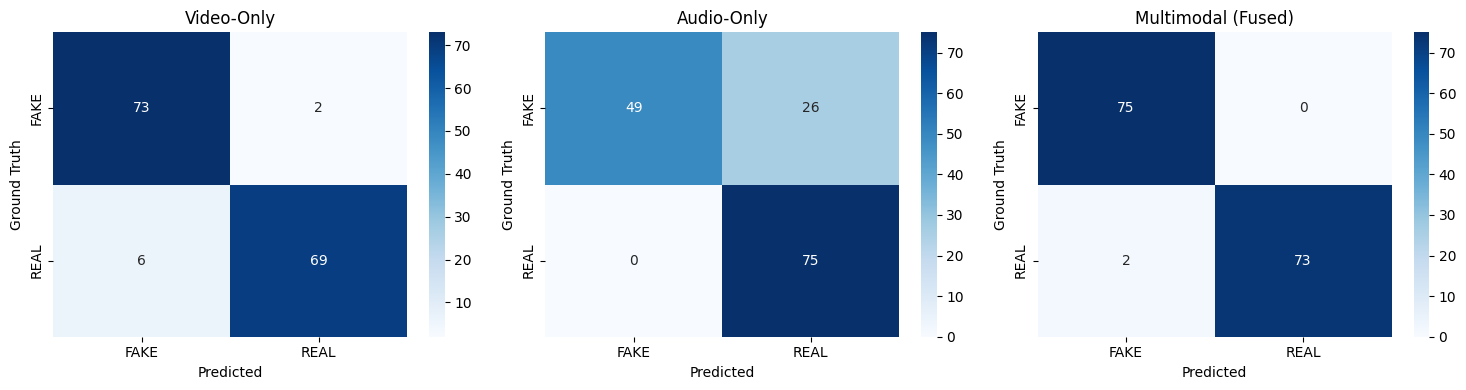

✅ Saved: confusion_matrices.png


In [ ]:
# GENERATE VISUALIZATIONS

# 1. Confusion Matrices
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

modalities = [
    ('video_pred', 'Video-Only'),
    ('audio_pred', 'Audio-Only'),
    ('fused_pred', 'Multimodal (Fused)')
]

for ax, (pred_col, title) in zip(axes, modalities):
    valid_mask = ~results_df[pred_col].isna()
    y_true = results_df.loc[valid_mask, 'ground_truth'].values
    y_pred = results_df.loc[valid_mask, pred_col].values

    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
               xticklabels=['FAKE', 'REAL'],
               yticklabels=['FAKE', 'REAL'])
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Ground Truth')
    ax.set_title(title)

plt.tight_layout()
plt.savefig('/content/confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ Saved: confusion_matrices.png")


In [ ]:
# CALCULATE METRICS
results_df = pd.DataFrame(results)

print("="*70)
print(" EVALUATION RESULTS")
print("="*70)

def calc_metrics(y_true, y_pred, y_prob=None, name=""):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    print(f"\n{name}:")
    print(f"  Accuracy:  {acc*100:.2f}%")
    print(f"  Precision: {prec*100:.2f}%")
    print(f"  Recall:    {rec*100:.2f}%")
    print(f"  F1-Score:  {f1*100:.2f}%")

    if y_prob is not None and len(set(y_true)) > 1:
        fpr, tpr, _ = roc_curve(y_true, y_prob)
        roc_auc = auc(fpr, tpr)
        print(f"  AUC-ROC:   {roc_auc:.4f}")

    return {'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1}

# Video-only
video_metrics = calc_metrics(
    results_df['ground_truth'],
    results_df['video_pred'],
    results_df['video_real_prob'],
    " VIDEO-ONLY"
)

# Audio-only
audio_valid = ~results_df['audio_pred'].isna()
if audio_valid.sum() > 0:
    audio_metrics = calc_metrics(
        results_df.loc[audio_valid, 'ground_truth'],
        results_df.loc[audio_valid, 'audio_pred'],
        results_df.loc[audio_valid, 'audio_real_prob'],
        "AUDIO-ONLY"
    )
else:
    audio_metrics = {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0}

# Multimodal
multimodal_metrics = calc_metrics(
    results_df['ground_truth'],
    results_df['fused_pred'],
    results_df['fused_real_prob'],
    "MULTIMODAL (FUSED)"
)


 EVALUATION RESULTS

 VIDEO-ONLY:
  Accuracy:  94.67%
  Precision: 97.18%
  Recall:    92.00%
  F1-Score:  94.52%
  AUC-ROC:   0.9944

AUDIO-ONLY:
  Accuracy:  82.67%
  Precision: 74.26%
  Recall:    100.00%
  F1-Score:  85.23%
  AUC-ROC:   0.8174

MULTIMODAL (FUSED):
  Accuracy:  98.67%
  Precision: 100.00%
  Recall:    97.33%
  F1-Score:  98.65%
  AUC-ROC:   0.9999


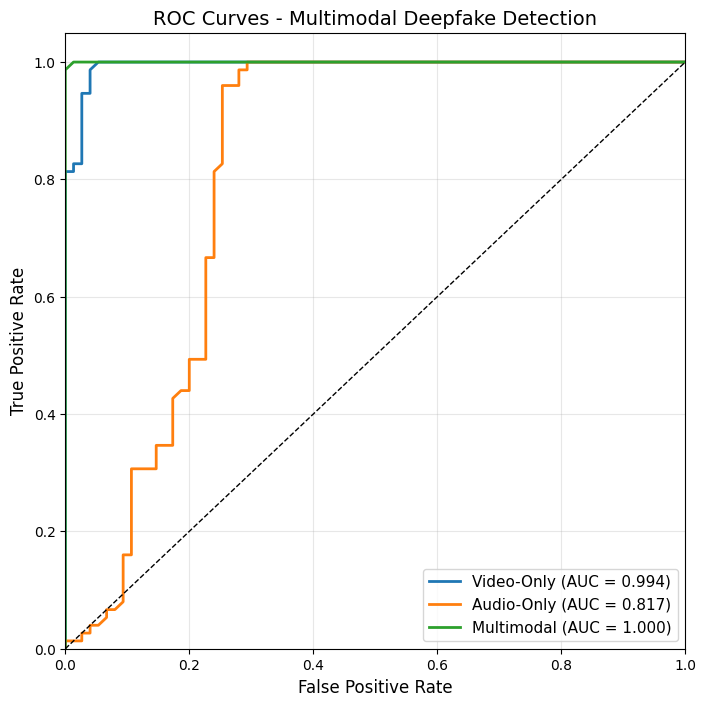

 Saved: roc_curves.png


In [ ]:
# ROC CURVES

plt.figure(figsize=(8, 8))

# Video
fpr, tpr, _ = roc_curve(results_df['ground_truth'], results_df['video_real_prob'])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, label=f'Video-Only (AUC = {roc_auc:.3f})')

# Audio
audio_valid = ~results_df['audio_real_prob'].isna()
if audio_valid.sum() > 0:
    fpr, tpr, _ = roc_curve(
        results_df.loc[audio_valid, 'ground_truth'],
        results_df.loc[audio_valid, 'audio_real_prob']
    )
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Audio-Only (AUC = {roc_auc:.3f})')

# Multimodal
fpr, tpr, _ = roc_curve(results_df['ground_truth'], results_df['fused_real_prob'])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, label=f'Multimodal (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Multimodal Deepfake Detection', fontsize=14)
plt.legend(loc='lower right', fontsize=11)
plt.grid(True, alpha=0.3)

plt.savefig('/content/roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()
print(" Saved: roc_curves.png")


In [ ]:
# ============================================================
# 📊 CELL 15FINAL SUMMARY FOR PAPER
print("\n" + "="*70)
print("📊 FINAL SUMMARY FOR PAPER")
print("="*70)

print(f"""
DATASET:
- FakeAVCeleb dataset
- Test samples: {len(results_df)} videos (balanced)
- REAL: {(results_df['ground_truth'] == 1).sum()}
- FAKE: {(results_df['ground_truth'] == 0).sum()}

RESULTS:
┌─────────────────┬──────────┬───────────┬────────┬──────────┐
│ Modality        │ Accuracy │ Precision │ Recall │ F1-Score │
├─────────────────┼──────────┼───────────┼────────┼──────────┤
│ Video-Only      │  {video_metrics['accuracy']*100:5.2f}%  │   {video_metrics['precision']*100:5.2f}%  │ {video_metrics['recall']*100:5.2f}% │  {video_metrics['f1']*100:5.2f}%  │
│ Audio-Only      │  {audio_metrics['accuracy']*100:5.2f}%  │   {audio_metrics['precision']*100:5.2f}%  │ {audio_metrics['recall']*100:5.2f}% │  {audio_metrics['f1']*100:5.2f}%  │
│ Multimodal      │  {multimodal_metrics['accuracy']*100:5.2f}%  │   {multimodal_metrics['precision']*100:5.2f}%  │ {multimodal_metrics['recall']*100:5.2f}% │  {multimodal_metrics['f1']*100:5.2f}%  │
└─────────────────┴──────────┴───────────┴────────┴──────────┘

KEY FINDINGS:
1. Multimodal fusion achieved {multimodal_metrics['accuracy']*100:.2f}% accuracy
2. Improvement over Video-only: {(multimodal_metrics['accuracy'] - video_metrics['accuracy'])*100:+.2f}%
3. Improvement over Audio-only: {(multimodal_metrics['accuracy'] - audio_metrics['accuracy'])*100:+.2f}%

""")




📊 FINAL SUMMARY FOR PAPER

DATASET:
- FakeAVCeleb dataset
- Test samples: 150 videos (balanced)
- REAL: 75
- FAKE: 75

RESULTS:
┌─────────────────┬──────────┬───────────┬────────┬──────────┐
│ Modality        │ Accuracy │ Precision │ Recall │ F1-Score │
├─────────────────┼──────────┼───────────┼────────┼──────────┤
│ Video-Only      │  94.67%  │   97.18%  │ 92.00% │  94.52%  │
│ Audio-Only      │  82.67%  │   74.26%  │ 100.00% │  85.23%  │
│ Multimodal      │  98.67%  │   100.00%  │ 97.33% │  98.65%  │
└─────────────────┴──────────┴───────────┴────────┴──────────┘

KEY FINDINGS:
1. Multimodal fusion achieved 98.67% accuracy
2. Improvement over Video-only: +4.00%
3. Improvement over Audio-only: +16.00%


